In [26]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math
import fceulib
import networkx as nx
import nxpd
import sets
# TODO: UnionFind, probably via import

In [27]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

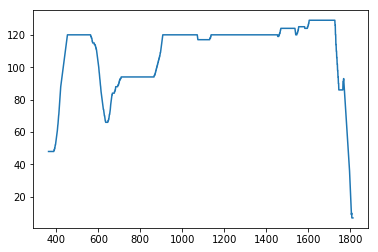

In [28]:
inputVec = fceulib.readInputs('movie.fm2')
collisions = pickle.load(open('collisions.pkl'))

(modes, path, merged, unions, track, all_times) = pickle.load(open("modes.pkl"))

plt.plot(track[:,0],track[:,1])
plt.show()
# TODO: define axis elsewhere?
axis = 2
velocities = track[1:,axis]-track[:-1,axis] 

In [29]:
start_time = 270
transitions = {}
# Edges into [outer] from [inner]
entries_from = {m: {m: [] for m in merged} 
                for m in merged}
# Edges into [outer]
entries = {m: [] for m in merged}
for t in range(1,len(path)):
    if t == 0:
        prev = -1
    else:
        prev = unions[t-1]
    start = path[t][1][0]
    entries_from[unions[t]][prev].append(start)
    entries[unions[t]].append(start)
    transitions[start] = (prev,unions[t])
    #print (path[t][1][0],start),":",prev,"->",unions[t],"\n",path[unions[t]][1][2][0],path[unions[t]][1][2][1].params

66 {'acc': -2.0000000000000022, 'type': 'accN', 'N': 4.0000000000000009}
35 {'type': 'cN', 'N': 2.4999999999999991}
4 {'type': 'c0'}
5 {'acc': 0.13939393939393963, 'type': 'accN', 'N': -4.1272727272727288}
6 {'acc': 0.37484737484737485, 'type': 'acc0'}
48 {'acc': 0.55164835164835169, 'type': 'accN', 'N': -3.8000000000000025}
53 {'acc': 0.35000000000000009, 'type': 'accN', 'N': 1.2666666666666666}
24 {'acc': -16.000000000000007, 'type': 'accN', 'N': 8.0000000000000036}
5 6 717253272144176202
24 4 64
6 35 10146177204226
35 4 12122149179189223228
35 66 158205
4 4 444751545560245248249252253256257260
4 24 62
66 4 160207
5 35 101116219
6 4 19283543507580244
5 4 135
5 48 86153185232
4 5 6162330668291125137151169181192209230
35 53 164
4 35 163
35 35 103117
4 6 414877224242
48 4 89241
48 35 157187236
53 4 167
35 48 238
35 5 106


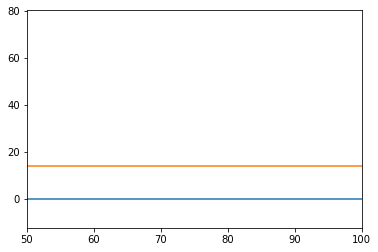

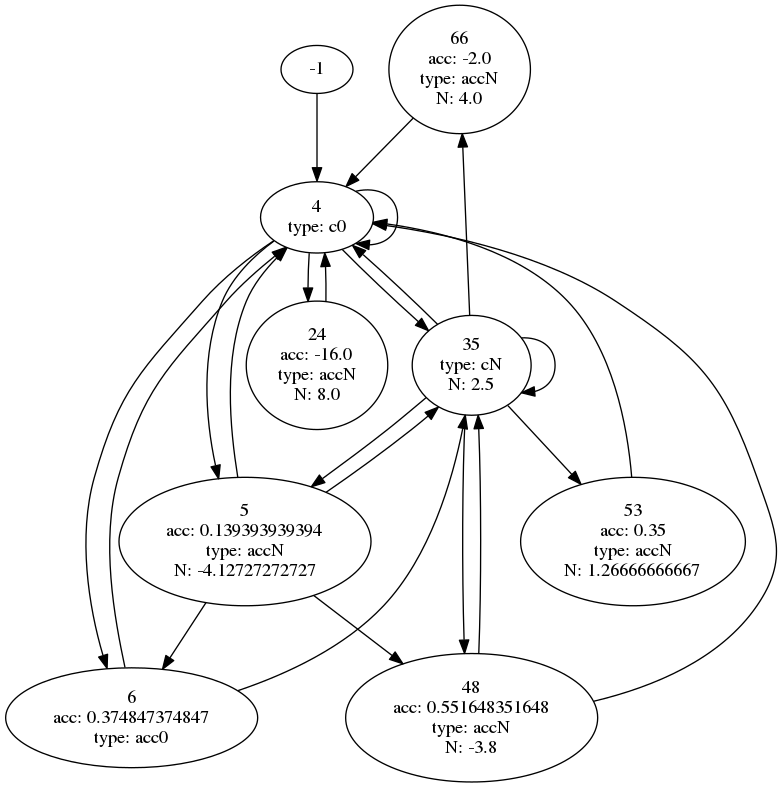

In [30]:
G = nx.MultiDiGraph()
to_add = {}
for tgt,srcs in entries_from.items():
    G.add_node(tgt,label=str(tgt))
    # Let's learn about tgt
    mtype = path[tgt][1][2][0]
    mparams = path[tgt][1][2][1].params
    params = {"type": mtype}
    if mtype == 'c0':
        pass
    elif mtype == 'cP':
        pass
    elif mtype == 'cN':
        params["N"] = mparams[1]
    elif mtype == 'acc0':
        params["acc"] = mparams[1]
    elif mtype == 'accP':
        params["acc"] = mparams[1]
    elif mtype == 'accN':
        params["N"] = mparams[1]
        params["acc"] = mparams[2]
    for k,v in params.items():
        G.node[tgt]["label"] = (G.node[tgt]["label"] + "\n" + "{}: {}".format(k,v))
    print tgt,params
    for src,times in srcs.items():
        for t in times:
            if (src,tgt) not in to_add:
                to_add[(src,tgt)] = []
            to_add[(src,tgt)].append('{}'.format(t))
for e in to_add:
    print e[0],e[1],''.join(to_add[e])
    G.add_edge(e[0],e[1])

G.add_node(-1)
G.add_edge(-1, unions[0])

m2i = {m:i for i,m in enumerate(merged)}
plt.plot(velocities)
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
for u in sorted(unions):
    t0 = all_times[path[u][1][0]]
    t1 = all_times[path[u][1][1]]
    u_ = m2i[unions[u]]
    plt.plot([t0,t1],[unions[u]+10,unions[u]+10])#,colors[u])
        
plt.xlim((50,100))
plt.show()


nxpd.draw(G, show='ipynb')

In [31]:

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        b_ = int(b)
        buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if b_ & (1 << (7-ii)):
                buttons.append(c)
        l_ = int(last_mask)
        last_buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if l_ & (1 << (7-ii)):
                last_buttons.append(c)
        mask_times[t] = (tuple(last_buttons),tuple(buttons))
        last_mask = b
    
    return mask_times

button_change_times = button_changes(inputVec)
for t in sorted(button_change_times):
    pass #print t, button_change_times[t]

In [32]:
def sign(num):
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

def button_diff(btnsA, btnsB):
    return set(btnsA) - set(btnsB)

def button_intersect(btnsA, btnsB):
    return set(btnsA) & set(btnsB)

def button_union(btnsA, btnsB):
    return set(btnsA) | set(btnsB)

def button_preds(button_pairs):
    here_i = set()
    for bp in button_pairs:
        released_i = button_diff(bp[0], bp[1])
        pressed_i = button_diff(bp[1], bp[0])    
        held_i = bp[1]
        for ri in released_i:
            here_i.add(("release",ri))
        for ri in pressed_i:
            here_i.add(("press",ri))
        for ri in held_i:
            here_i.add(("hold",ri))
    return list(here_i)

In [33]:
preds = [set()]*len(velocities)
for t in range(0,len(velocities)):
    psi = ([button_change_times[start_time+t+i]
            for i in range(0, 1)],
            #  TODO: stopped colliding/started colliding?  That would mean
           #   I could say "started colliding with X on bottom and also zin,-1"
           #   to help find solid things.
           #     ... no... acc,0 should be enough (walking right across solid tiles)
           #     but I should also consider 
           #     a more sophisticated notion of collision.
           #      e.g. "bottom" is good but it should be the lowest bottom tile.
           #      how can I get that?  can I get that?
           #      (OTOH, maybe this isn't even necessary if e.g. "touching my feet against sky"
          #        doesn't cause vy=0 as often as "touching my feet against ground" does. so let's be
          #         sure that's surfaced!)
            collisions.get(start_time+t+(0),set()),
            (velocities[t-1],velocities[t-0])
          )
    buttons_i = psi[0]
    here_i = button_preds(buttons_i)
    for coli in psi[1]:
        here_i.append(("col",coli))
    vel0,vel1 = psi[2]
    if vel0 < vel1:
        here_i.append(("acc",1))
    if vel0 > vel1:
        here_i.append(("acc",-1))
    if vel0 == vel1:
        here_i.append(("acc",0))
    if vel1 < 0:
        here_i.append(("vel",-1))
    if vel1 > 0:
        here_i.append(("vel",1))
    if vel1 == 0:
        here_i.append(("vel",0))
    if vel0 < 0 and vel1 > 0:
        here_i.append(("zc",1))
    if vel0 > 0 and vel1 < 0:
        here_i.append(("zc",-1))
    if vel0 < 0 and vel1 == 0:
        here_i.append(("zin",1))
    if vel0 > 0 and vel1 == 0:
        here_i.append(("zin",-1))
    if vel0 == 0 and vel1 < 0:
        here_i.append(("zout",-1))
    if vel0 == 0 and vel1 > 0:
        here_i.append(("zout",1))
    #cur_mode = X
    # TODO: touched global min/max of velocity for current mode
    #mode_max = max(velocities_in_cur_mode)
    #mode_min = min(velocities_in_cur_mode)
    #if vel1 == mode_max and vel0 != mode_max:
    #  touched max
    #if vel1 == mode_min and vel0 != mode_min:
    #  touched min
    #if vel1 == mode_max:
    #  in min
    #if vel1 == mode_min:
    #  in max
    preds[t] = set(here_i)



In [34]:


def count_cooccurrences(pred_sets,ignored):
    ocs = {}
    coocs = {}
    nice_pred_sets = []
    for pi in range(0, len(pred_sets)):
        here_i = pred_sets[pi]
        here_i = list(set(here_i) - ignored)
        for pred in here_i:
            ocs[pred] = ocs.get(pred,0)+1
        for predii in range(0,len(here_i)):
            if here_i[predii] not in coocs:
                coocs[here_i[predii]] = {}
            for predij in range(0,len(here_i)):
                coocs[here_i[predii]][here_i[predij]] = coocs[here_i[predii]].get(here_i[predij],0)+1
        nice_pred_sets.append(here_i)
    return nice_pred_sets,ocs,coocs


def calc_npmi(pred_sets, ocs, coocs):
    maximum = float(len(pred_sets))
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in ocs.items():
        px = countx / maximum
        probs[predx] = px
        for predy,countxy in coocs[predx].items():
            py = ocs[predy] / maximum
            pxy = countxy / maximum
            d = (math.log(px*py)/math.log(pxy) - 1) if pxy != 1 else 1
            npmis[(predx,predy)] = d
    return probs,npmis

def calc_npmi_pred_edge(all_ocs, all_edge_ocs, edge_count, all_edge_count):
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in all_ocs.items():
        px = countx / float(all_edge_count)
        py = edge_count / float(all_edge_count)
        pxy = all_edge_ocs.get(predx,0) / float(all_edge_count)
        probs[predx] = all_edge_ocs.get(predx,0) / float(edge_count)
        assert px <= 1, (px,countx,all_edge_count)
        assert py <= 1, (py,edge_count,all_edge_count)
        assert pxy <= 1, (pxy,all_edge_ocs.get(predx,0),float(edge_count))
        if pxy == 0:
            d = -1
        elif pxy == 1:
            d = 1
        else:
            d = (math.log(px*py)/math.log(pxy) - 1)
        npmis[predx] = d
    return probs,npmis

def calc_npmi(pred1, pred2, all_counts, counts_by_time):
    norm = float(len(counts_by_time)+1)
    count1 = all_counts[pred1]
    count2 = all_counts[pred2]
    count12 = 0
    for t,cs in counts_by_time.items():
        count12 += cs.get(pred1,0) * cs.get(pred2,0)
    p1 = count1 / norm
    p2 = count2 / norm
    p12 = count12 / norm
    if p12 == 0:
        d = -1
    elif p12 == 1:
        d = 1
    else:
        d = math.log(p1*p2)/math.log(p12) - 1
    return d

def weight_npmi(npmi, things):
    net_weight = 0
    WEIGHT_HIGH = 1.00
    WEIGHT_MID = 0.75
    WEIGHT_NORMAL = 0.50
    for t in things:
        weight = WEIGHT_NORMAL
        type = t[0]
        if type == "tr" or type == "press" or type == "release":
            weight = WEIGHT_HIGH
        elif type == "hold" or type == "col":
            weight = WEIGHT_MID
        else:
            weight = WEIGHT_NORMAL
        net_weight += weight
    weight = net_weight / float(len(things))
    return (npmi * weight)


In [35]:
def count_events(preds):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        for p in ps:
            all_counts[p] = all_counts.get(p,0)+1
            counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            tr = transitions[t]
            key = ("tr",tr)
            all_counts[key] = all_counts.get(key,0)+1
            counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
            (_,dest) = tr
            keystar = ("tr",("*",dest))
            all_counts[keystar] = all_counts.get(keystar,0)+1
            counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

all_counts,counts_by_time = count_events(preds)
all_counts,counts_by_time

({('acc', -1): 127,
  ('acc', 0): 1109,
  ('acc', 1): 213,
  ('col', ((16, 17, 14, 15), 'right')): 4,
  ('col', ((16, 18, 19, 14), 'right')): 2,
  ('col', ((24, 23), 'bottom')): 4,
  ('col', ((36, 0, 'tile'), 'bottom')): 1264,
  ('col', ((36, 0, 'tile'), 'internal')): 1280,
  ('col', ((36, 0, 'tile'), 'left')): 1228,
  ('col', ((36, 0, 'tile'), 'right')): 1205,
  ('col', ((36, 0, 'tile'), 'top')): 689,
  ('col', ((36, 1, 'tile'), 'bottom')): 13,
  ('col', ((36, 1, 'tile'), 'internal')): 11,
  ('col', ((36, 1, 'tile'), 'left')): 8,
  ('col', ((36, 1, 'tile'), 'right')): 5,
  ('col', ((36, 2, 'tile'), 'bottom')): 10,
  ('col', ((36, 2, 'tile'), 'internal')): 10,
  ('col', ((36, 2, 'tile'), 'left')): 12,
  ('col', ((36, 2, 'tile'), 'right')): 1,
  ('col', ((36, 3, 'tile'), 'bottom')): 9,
  ('col', ((36, 3, 'tile'), 'internal')): 6,
  ('col', ((36, 3, 'tile'), 'left')): 6,
  ('col', ((37, 0, 'tile'), 'internal')): 133,
  ('col', ((37, 0, 'tile'), 'left')): 101,
  ('col', ((37, 0, 'tile'), 

----
top
----
1.0 (181, 1, 'tile')


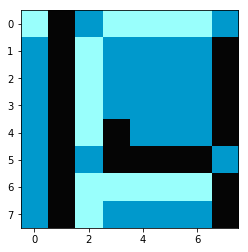

1.0 (180, 1, 'tile')


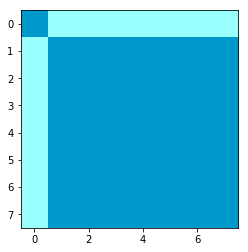

----
right
----
1.0 (36, 0, 'tile')


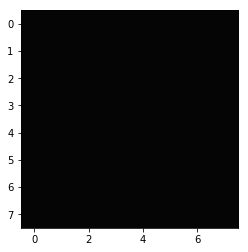

----
left
----
1.0 (36, 0, 'tile')


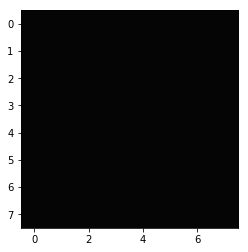

----
bottom
----
1.0 (64, 65, 66, 67, 68, 53, 54, 63)


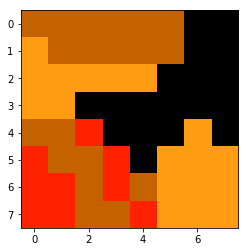

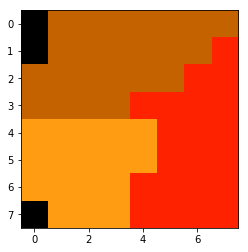

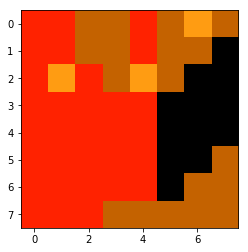

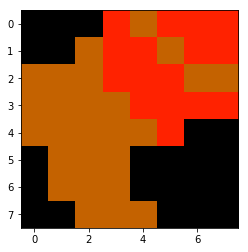

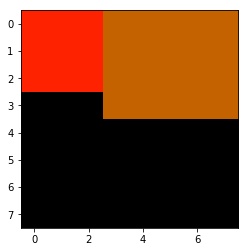

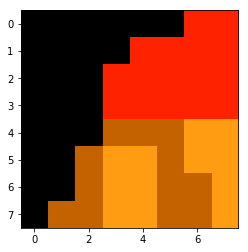

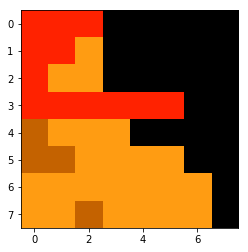

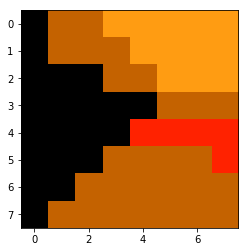

1.0 (69, 70, 71, 72, 73, 74, 75, 76)


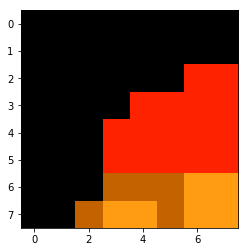

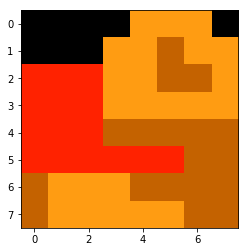

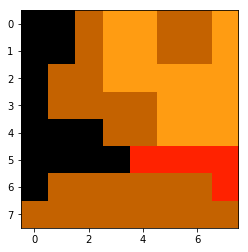

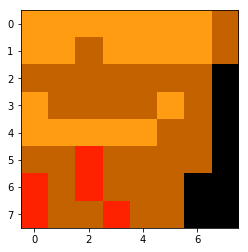

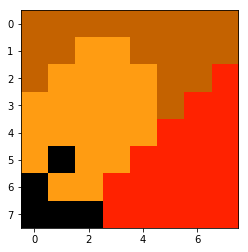

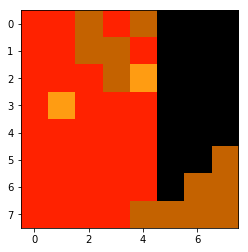

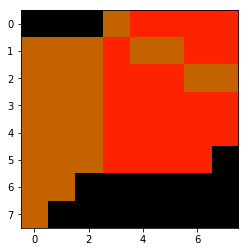

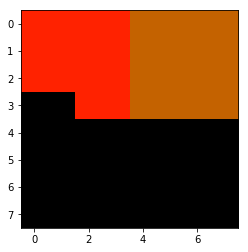

1.0 (36, 0, 'tile')


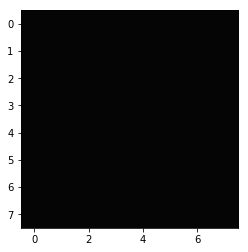

In [25]:

tile2colorized = pickle.load(open('tile2colorized.pkl'))
id2colorized = pickle.load(open('id2sprites.pkl'))[1]

# Let's figure out which tiles block movement on which sides!
# co-occurrence of (col, BLAH) and acc0 for each BLAH.
# cluster together tiles which block on a given side (for now, all those with co-occurrence over threshold)
# then add new preds!

def cond_prob(e1s, e2, all_counts, counts_by_time):
    p2 = all_counts[e2]/float(len(counts_by_time))
    count12 = 0
    count1 = 0
    for t,cs in counts_by_time.items():
        any_e1_present = True
        for e1 in e1s:
            if e1 not in cs:
                any_e1_present = False
                break
        if any_e1_present:
            count1 += 1
        if any_e1_present and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time))
    return p12 / p2

block_chance = {}
for thing,count in all_counts.items():
    # TODO: generalize back to all sides, but note "colliding on right with something" -> "vely=0" is not that sensible.
    #  need a notion of acc,vel,zin,zout and _other axis_ acc,vel,zin,zout.
    if thing[0] != "col": 
        continue
    block_chance[thing] = cond_prob([("vel",0),("acc",0)], 
                                    thing,
                                    all_counts,
                                    counts_by_time)

merged_by_side = {}
# TODO: generalize back to all sides
for side in ["bottom","right","left","top"]:
    # Let's pretend colliding with sprites is the same as colliding with tiles?  Maybe needed for moving platforms?
    blockings = filter(lambda (col,prob):(col[1][0][0] != "solid" and 
                                          col[1][1] == side and 
                                          prob > 0.8),
                       block_chance.items())
    merged_by_side[side] = set()
    for bcol,bprob in blockings:
        merged_by_side[side].add(bcol)
    merged_by_side[side] = sets.ImmutableSet(merged_by_side[side])
        
    
#color_tiles = pickle.load(open('tile2colorized.pkl'))
for side,bcols in merged_by_side.items():
    print "----\n{}\n----".format(side)
    for bc in bcols:
        print block_chance[bc],bc[1][0]        
        if 'tile' in bc[1][0]:
            plt.imshow(tile2colorized[bc[1][0][:2]]/255.)
            plt.show()
        else:
            for sprite in bc[1][0]:
                plt.imshow(id2colorized[sprite][:,:,:3]/255.)
                plt.show()

In [12]:
# Let's add new preds now!
new_preds = [set() for i in range(0,len(preds))]
for t,pset in enumerate(preds):
    for side,equiv in merged_by_side.items():
        found = False
        for pred in pset:
            new_preds[t].add(pred)
            if not found and pred[0] == "col" and pred in equiv:
                new_preds[t].add(("col", (("solid", equiv), side)))
                found = True
all_counts,counts_by_time = count_events(new_preds)


all_counts,counts_by_time

({('acc', -1): 460,
  ('acc', 0): 2516,
  ('acc', 1): 795,
  ('col', ((35, 36, 38, 39), 'right')): 8,
  ('col', ((35, 36, 38, 39), 'top')): 2,
  ('col', ((36, 0, 'tile'), 'bottom')): 3588,
  ('col', ((36, 0, 'tile'), 'internal')): 3601,
  ('col', ((36, 0, 'tile'), 'left')): 3435,
  ('col', ((36, 0, 'tile'), 'right')): 3517,
  ('col', ((36, 0, 'tile'), 'top')): 2521,
  ('col', ((36, 1, 'tile'), 'bottom')): 20,
  ('col', ((36, 1, 'tile'), 'internal')): 9,
  ('col', ((36, 1, 'tile'), 'left')): 2,
  ('col', ((36, 1, 'tile'), 'right')): 11,
  ('col', ((36, 3, 'tile'), 'bottom')): 14,
  ('col', ((36, 3, 'tile'), 'internal')): 9,
  ('col', ((36, 3, 'tile'), 'left')): 2,
  ('col', ((36, 3, 'tile'), 'right')): 7,
  ('col', ((37, 0, 'tile'), 'internal')): 181,
  ('col', ((37, 0, 'tile'), 'left')): 167,
  ('col', ((37, 0, 'tile'), 'right')): 56,
  ('col', ((37, 0, 'tile'), 'top')): 61,
  ('col', ((38, 0, 'tile'), 'bottom')): 149,
  ('col', ((38, 0, 'tile'), 'internal')): 310,
  ('col', ((38, 0, '

In [13]:
# Let's calculate NPMI between predicates and transitions!
npmis = {}
for thing,count in all_counts.items():
    if thing[0] == "tr":
        print "tr:",thing,count
        tr = thing[1]
        # Find NPMI with every predicate
        for thing2,count in all_counts.items():
            if thing2[0] == "tr":
                continue
            if tr not in npmis:
                npmis[tr] = {}
            npmis[tr][(thing2,)] = weight_npmi(
                calc_npmi(thing, 
                          thing2, 
                          all_counts,
                          counts_by_time),
                [thing2]
            )
    else:
        pass

for tr,prednpmis in npmis.items():
    if tr[1] != 5: continue
    print "----"
    print tr
    print "----"
    for pred,pmi in sorted(prednpmis.items(),
                           lambda a,b:sign(b[1]-a[1])):
        if pmi > 0:
            print pred,pmi

tr: ('tr', (5, 4)) 12
tr: ('tr', (230, 4)) 1
tr: ('tr', (5, 7)) 12
tr: ('tr', (5, 6)) 39
tr: ('tr', (4, 230)) 1
tr: ('tr', (4, 5)) 57
tr: ('tr', (4, 7)) 4
tr: ('tr', ('*', 90)) 5
tr: ('tr', (6, 5)) 1
tr: ('tr', (4, 4)) 10
tr: ('tr', (6, 7)) 31
tr: ('tr', ('*', 6)) 43
tr: ('tr', (90, 7)) 2
tr: ('tr', ('*', 5)) 75
tr: ('tr', ('*', 4)) 75
tr: ('tr', ('*', 8)) 1
tr: ('tr', (7, 8)) 1
tr: ('tr', (5, 90)) 5
tr: ('tr', (5, 5)) 7
tr: ('tr', (7, 5)) 10
tr: ('tr', (4, 6)) 4
tr: ('tr', (8, 4)) 1
tr: ('tr', (7, 4)) 37
tr: ('tr', (90, 4)) 3
tr: ('tr', (37, 4)) 2
tr: ('tr', (6, 4)) 9
tr: ('tr', (6, 37)) 2
tr: ('tr', ('*', 7)) 49
tr: ('tr', ('*', 37)) 2
tr: ('tr', ('*', 230)) 1
----
(5, 5)
----
(('col', ((52, 0, 'tile'), 'top')),) 0.228155842454
(('col', ((52, 0, 'tile'), 'bottom')),) 0.162983829894
(('col', ((51, 0, 'tile'), 'bottom')),) 0.16098219563
(('hold', 'B'),) 0.150696634129
(('col', ((51, 0, 'tile'), 'right')),) 0.146379679388
(('col', ((38, 0, 'tile'), 'top')),) 0.127417130864
(('col', ((52

In [14]:
# TODO: this gives different results if e2, e3 in different 
#  orders.  Seems wrong!
def calc_npmi_chained(e1,e2,e3,all_counts,counts_by_time):
    p1 = all_counts[e1] / float(len(counts_by_time)+1)
    p2 = all_counts[e2] / float(len(counts_by_time)+1)
    if p1 == 0:
        assert(False)
        print "p1=0"
        return -1
    if p2 == 0:
        assert(False)
        print "p2=0"
        return -1
    count12 = 0
    for t,cs in counts_by_time.items():
        if (e1 in cs) and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time)+1)
    if p12 == 0:
        # Never co-occur, avoid log(0)
        return -1
    pmi12 = math.log(p12 / (p1 * p2))
    #p(event ,  causeB| causeA)/ (p(event | causeA) * p(causeB | causeA))
    times_1_and_3_and_2_happen = 0
    times_3_and_2_happen = 0
    times_any_happen = 0
    for t,cs in counts_by_time.items():
        if (e1 in cs) and (e3 in cs) and (e2 in cs):
            times_1_and_3_and_2_happen += 1
        if (e3 in cs) and (e2 in cs):
            times_3_and_2_happen += 1
        if (e1 in cs) or (e2 in cs) or (e3 in cs):
            times_any_happen += 1
    p132 = times_1_and_3_and_2_happen/float(len(counts_by_time)+1)
    if p132 == 0:
        # Never co-occur, avoid log(0)
        return -1
    # TODO: P(x,(z|y)) or P((x,z)|y)?  this looks like the latter.  Because the former makes no sense?
    p13_2 = (p132/p2)
    p32 = times_3_and_2_happen / float(len(counts_by_time)+1)
    p3_2 = p32/p2
    if p13_2 == 0:
        # Never co-occur, avoid log(0)
        return -1
    elif p3_2 == 0:
        # Never co-occur, avoid log(0)
        return -1
    pmi1_23 = math.log(p13_2/(p1 * p3_2))
    # normalize by log(p(event;causeA;causeB))??? no...
    # Normalize by self-information!
    return (pmi12 + pmi1_23)/(2*(-math.log(p132)))

# Let's calculate the NPMI of causal pairs with each transition!
paired_npmis = {}
for thing,count in all_counts.items():
    if thing[0] == "tr":
        print "tr:",thing,count
        tr = thing[1]
        if tr not in paired_npmis:
            paired_npmis[tr] = {}
        # Find NPMI with every predicate
        for thing2,count2 in all_counts.items():
            if thing2[0] == "tr":
                continue
            for thing3,count3 in all_counts.items():
                if thing3[0] == "tr" or thing3 == thing2:
                    continue
                key = (thing2,thing3)
                paired_npmis[tr][key] = weight_npmi(
                    calc_npmi_chained(thing,
                                      thing2,
                                      thing3,
                                      all_counts,
                                      counts_by_time),
                    [thing2,thing3]
                )
        print "\n".join(
            map(str,
                sorted(filter(
                        lambda (k,v): v > 0,
                        paired_npmis[tr].items()),
                       lambda a,b:sign(b[1]-a[1]))))
        
    else:
        pass

tr: ('tr', (5, 4)) 12
((('release', 'R'), ('hold', 'A')), 0.257618899985082)
((('zin', -1), ('col', ((52, 0, 'tile'), 'right'))), 0.23351286313584907)
((('release', 'R'), ('acc', 1)), 0.2322598895452198)
((('zin', -1), ('col', ((52, 0, 'tile'), 'left'))), 0.22259644410696627)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'top'))), 0.2222923192308172)
((('col', ((52, 0, 'tile'), 'right')), ('zin', -1)), 0.2207450465832267)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'left'))), 0.2165435189865908)
((('release', 'R'), ('vel', -1)), 0.21601857240527422)
((('col', ((52, 0, 'tile'), 'left')), ('zin', -1)), 0.21522897628892712)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'right'))), 0.21519852130254535)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'bottom'))), 0.21519852130254535)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'internal'))), 0.21388673685549972)
((('zin', -1), ('col', ((38, 0, 'tile'), 'bottom'))), 0.207210615633272)
((('zin', -1), ('col', ((38, 0, 'tile'), 'right'))), 0.

KeyboardInterrupt: 

In [ ]:
relevance_threshold = 0.1
universality_threshold = 0.8
negation_threshold = -1.0

for tr,pred_npmis in npmis.items():# + paired_npmis.items():
    if tr[1] != 5: continue

    cond_probs = {k: cond_prob(list(k), ("tr",tr), all_counts, counts_by_time) for k in pred_npmis.keys()}
    #print pred_npmis
    relevants = {k: npmi for (k,npmi) in pred_npmis.items() if npmi >= relevance_threshold}
    negations = {k: npmi for (k,npmi) in pred_npmis.items() if npmi <= negation_threshold}
    conjuncts = set(filter(lambda k:cond_probs[k] >= universality_threshold, relevants.keys()))
    disjuncts = set(filter(lambda k:cond_probs[k] < universality_threshold, relevants.keys()))
    print "-------\nTransition:",tr
    print "\n".join(map(str,cond_probs.items()))
    print "-----\nRelevant:\n","\n".join(map(str,relevants.keys()))
    print "-----\nConjuncts:\n"," & ".join(map(str,conjuncts))
    print "-----\nDisjuncts:\n"," | ".join(map(str,disjuncts))
    print "-----\nNegations:\n"," & ".join(map(lambda k:"~" + str(k),negations))
    
    


In [ ]:
pickle.dump((npmis, paired_npmis, entries, entries_from, new_preds, modes, merged, unions, track, inputVec, all_times), 
            open("edges.pkl",'wb'))